In [1]:
import sys
 
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '../')
import myTA
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import warnings



from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from matplotlib import pyplot
from scipy.stats import linregress

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [241]:
# Pivot finding
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.Low[l]>df1.Low[i]):
            pividlow=0
        if(df1.High[l]<df1.High[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0

def pointpos(x):
    if x['pivot']==1:
        return x['Low']-1e-3
    elif x['pivot']==2:
        return x['High']+1e-3
    else:
        return np.nan

# Patterns finding
def fitTrianglesForCandle(df, candleid, backcandles=20):
    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].Low)
            xxmin = np.append(xxmin, i)
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].High)
            xxmax = np.append(xxmax, i)

    slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
    slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
    return slmin, intercmin, rmin, pmin, semin, slmax, intercmax, rmax, pmax, semax, xxmin, minim, xxmax, maxim

def searchForValidCandles(df, backcandles=20):
    validCandles = []
    for candleid in range(1, len(df)):
        maxim = np.array([])
        minim = np.array([])
        xxmin = np.array([])
        xxmax = np.array([])
        for i in range(candleid-backcandles, candleid+1):
            if df.iloc[i].pivot == 1:
                minim = np.append(minim, df.iloc[i].Low)
                xxmin = np.append(xxmin, i)
            if df.iloc[i].pivot == 2:
                maxim = np.append(maxim, df.iloc[i].High)
                xxmax = np.append(xxmax, i)

        if (xxmax.size <3 and xxmin.size <3) or xxmax.size==0 or xxmin.size==0:
            continue

        slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
        slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
            
        if abs(rmax)>=0.9 and abs(rmin)>=0.9 and slmin>=0.0001 and slmax<=-0.0001:
            validCandles.append(candleid)
    return validCandles

def visualizeValidCandle(df, candleid, backcandles=20, visualize=False):
    slmin, intercmin, rmin, pmin, semin, slmax, intercmax, rmax, pmax, semax, xxmin, minim, xxmax, maxim = fitTrianglesForCandle(df, candleid, backcandles)
    dfpl = df[candleid-backcandles-30:candleid+backcandles+30]

    xxmin = np.append(xxmin, np.max([xxmin[-1], xxmax[-1]]))
    xxmax = np.append(xxmax, np.max([xxmin[-1], xxmax[-1]]))


    triangle = pd.DataFrame(columns=['x', 'ymin', 'ymax', 'min', 'max'])
    x = candleid - backcandles
    ymin = slmin*x + intercmin
    ymax = slmax*x + intercmax

    while ymin < ymax:
        ymin = slmin*x + intercmin
        ymax = slmax*x + intercmax
        triangle = pd.concat([triangle, pd.DataFrame({'x':[x], 'ymin':[ymin], 'ymax':[ymax], 'min':[df.iloc[x].Low], 'max':[df.iloc[x].High]})])
        x += 1
    triangle.set_index('x', inplace=True)

    if visualize:
        fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['Open'],
                        high=dfpl['High'],
                        low=dfpl['Low'],
                        close=dfpl['Close'])])
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                        marker=dict(size=4, color="MediumPurple"),
                        name="pivot")
        fig.add_scatter(x=[candleid], y=[df.iloc[candleid].Close-2e-3], mode="markers",
                        marker=dict(size=6, color="Blue"),
                        name="pattern till")
        fig.add_trace(go.Scatter(x=xxmin, y=slmin*xxmin + intercmin, mode='lines', name='min slope'))
        fig.add_trace(go.Scatter(x=xxmax, y=slmax*xxmax + intercmax, mode='lines', name='max slope'))
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

        triangle.plot(figsize=(25,7))
        plt.vlines(candleid, triangle['ymin'].min(), triangle['ymin'][candleid], linestyles='--', colors='orange')
        plt.show()
    return triangle

# Opportunity Class
class Opportunity:
    def __init__(self, df, triangle, candleid, backcandles) -> None:
        self.df = df
        self.triangle = triangle
        self.candleid = candleid
        self.backcandles = backcandles

        priorDataTimeWindow = 30
        priorData = self.df.iloc[np.max([candleid-priorDataTimeWindow, 0]):candleid]
        self.priorData = priorData
        self.priorTrend = {
            'min': priorData['Low'].min(),
            'max': priorData['High'].max(),
            'volatility%': (priorData['High'].max()-priorData['Low'].min())/priorData.iloc[-1].Close*100,
            'change': priorData.iloc[-1].Close-priorData.iloc[0].Open
        }
        self.momentum = 'bullish' if self.priorTrend['change'] > 0 else 'bearish'

        self.enterIndex, self.breakOutSignal = Opportunity.whenToEnterAndSignal(self.triangle, self.candleid, self.backcandles)
        self.enterIndex += 1 # one day delay, this is in times (days, h...) after candleid

        self.enterPrice = self.df.loc[self.candleid+self.enterIndex, 'Open'] # assume we buy at open

        self.kind = 'long' # 'long' 'short'  # for now I'' only do Long as we don't determin optimal kind of trade so far
        returnsTimeFrame = 50
        self.returns = self.df.loc[self.candleid+self.enterIndex:self.candleid+self.enterIndex+returnsTimeFrame]['Close'] - self.enterPrice


        # TODO
        # determine optimal kind of trade
    def determineContinuation(self):
        self.enterIndex, self.breakOutSignal = Opportunity.whenToEnterAndSignal(self.triangle, self.candleid, self.backcandles)

    def plotEverything(self):
        dfpl = self.df[self.candleid-self.backcandles-30:self.candleid+self.backcandles+30]
        fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['Open'],
                        high=dfpl['High'],
                        low=dfpl['Low'],
                        close=dfpl['Close'])])
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                        marker=dict(size=4, color="MediumPurple"),
                        name="pivot")
        fig.add_scatter(x=[self.candleid], y=[df.iloc[self.candleid].Close-2e-3], mode="markers",
                        marker=dict(size=6, color="Blue"),
                        name="pattern till")

        fig.add_trace(go.Scatter(x=self.triangle.index.values, y=self.triangle['ymin'].values, mode='lines', name='min slope'))
        fig.add_trace(go.Scatter(x=self.triangle.index.values, y=self.triangle['ymax'].values, mode='lines', name='max slope'))
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

        self.triangle.plot(figsize=(25,7))
        try: # sometimes triangle can end before candleid
            plt.vlines(self.candleid, self.triangle['ymin'].min(), self.triangle['ymin'][self.candleid], linestyles='--', colors='orange')
        except:
            pass
        plt.title(f"momentum: {self.momentum} breakout signal: {self.breakOutSignal}")
        plt.show()

        self.returns.plot(figsize=(25,7))
        plt.title(f"momentum: {self.momentum}           breakout signal: {self.breakOutSignal}")
        plt.show()

    def whenToEnterAndSignal(triangle, candleid, backcandles):
        val = 0
        for i in range(backcandles, len(triangle)):
            if triangle.iloc[i]['max'] > triangle.iloc[i]['ymax']:
                val += triangle.iloc[i]['max'] - triangle.iloc[i]['ymax']
            if triangle.iloc[i]['min'] < triangle.iloc[i]['ymin']:
                val -= triangle.iloc[i]['ymin'] - triangle.iloc[i]['min']
            if val/((triangle.loc[candleid, 'min']+triangle.loc[candleid, 'max'])/2) < -0.1:
                return i-backcandles , 'bearish'
            if val/((triangle.loc[candleid, 'min']+triangle.loc[candleid, 'max'])/2) > 0.1:
                return i-backcandles , 'bullish'
        return 0, 'bullish' if val > 0 else 'bearish'

# automated analysis
def showPatterns(df, backcandles):
    df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    print("data analyzed")

    warnings.filterwarnings("ignore")
    validCandles = searchForValidCandles(df, backcandles=backcandles)
    print("Valid candles found, printing plots...")
    for validCandle in np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]:
        print(f"------------------------ validCandle: {validCandle} ------------------------")
        triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
        opportunity = Opportunity(df, triangle, validCandle, backcandles)
        # opportunity.plotEverything()
    warnings.filterwarnings("default")

In [244]:
code = "AMZN"
df = myTA.downloadAndMakeAnalysis(code, dt.datetime(2021,1,1), dt.datetime.now(),'1d').reset_index()
df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
df

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,macd,macd_signal,macd_hist,SMA200,SMA100,pivot,pointpos
0,2020-12-31,371.779999,374.660004,371.230011,373.880005,363.071564,78520700,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2021-01-04,375.309998,375.450012,364.820007,368.790009,358.128723,110210800,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2021-01-05,368.100006,372.500000,368.049988,371.329987,360.595276,66426200,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,2021-01-06,369.709991,376.980011,369.119995,373.549988,362.751099,107997700,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2021-01-07,376.100006,379.899994,375.910004,379.100006,368.140686,68766800,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2022-12-23,379.649994,383.059998,378.029999,382.910004,382.910004,59857300,43.304807,-2.469546,-0.205385,-2.264161,400.793601,390.736301,0,NaN
500,2022-12-27,382.790009,383.149994,379.649994,381.399994,381.399994,51638200,42.136131,-2.791225,-0.722553,-2.068672,400.600251,390.408601,0,NaN
501,2022-12-28,381.329987,383.390015,376.420013,376.660004,376.660004,70911500,38.613407,-3.389563,-1.255955,-2.133608,400.398551,390.040501,0,NaN
502,2022-12-29,379.630005,384.350006,379.079987,383.440002,383.440002,66970900,45.617043,-3.278865,-1.660537,-1.618328,400.184901,389.745001,0,NaN


In [233]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,macd,macd_signal,macd_hist,SMA200,SMA100,pivot,pointpos
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,19.819923,-17.244768,-13.664886,-3.579883,255.097317,234.019467,0,NaN
3146,2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,16.564126,-19.072995,-14.746507,-4.326487,254.317234,232.024134,0,NaN
3147,2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,20.191722,-20.000032,-15.797212,-4.202820,253.603501,230.269534,0,NaN
3148,2022-12-29,120.389999,123.570000,117.500000,121.820000,121.820000,221923300,28.625201,-19.771700,-16.592110,-3.179590,252.876117,228.583501,0,NaN


In [245]:
code='SPY'
df = myTA.downloadAndMakeAnalysis(code, dt.datetime(2000,1,1), dt.datetime.now(),'1d').reset_index()
df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
print("data analyzed")

warnings.filterwarnings("ignore")
validCandles = searchForValidCandles(df, backcandles=backcandles)
print("Valid candles found, printing plots...")
for validCandle in np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]:
    print(f"------------------------ validCandle: {validCandle} ------------------------")
    triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
    opportunity = Opportunity(df, triangle, validCandle, backcandles)
    # opportunity.plotEverything()
warnings.filterwarnings("default")

data analyzed
Valid candles found, printing plots...
------------------------ validCandle: 347 ------------------------
------------------------ validCandle: 378 ------------------------
------------------------ validCandle: 553 ------------------------
------------------------ validCandle: 1631 ------------------------
------------------------ validCandle: 2162 ------------------------
------------------------ validCandle: 2177 ------------------------
------------------------ validCandle: 2510 ------------------------
------------------------ validCandle: 2515 ------------------------
------------------------ validCandle: 2623 ------------------------
------------------------ validCandle: 2946 ------------------------
------------------------ validCandle: 3659 ------------------------
------------------------ validCandle: 3779 ------------------------
------------------------ validCandle: 4215 ------------------------
------------------------ validCandle: 4941 -----------------------

In [242]:
opportunity = Opportunity(df, triangle, validCandle, backcandles)

In [232]:
code='TSLA'
df = myTA.downloadAndMakeAnalysis(code, dt.datetime(2000,1,1), dt.datetime.now(),'1d').reset_index()
showPatterns(df, backcandles=20)

data analyzed
Valid candles found, printing plots...
------------------------ validCandle: 25 ------------------------


IndexError: single positional indexer is out-of-bounds

## Pivot Candles Vizualisation

In [4]:
dfpl = df
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.show()

In [213]:
warnings.filterwarnings("ignore")
validCandles = searchForValidCandles(df, backcandles=20)
warnings.filterwarnings("default")
for validCandle in np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]:
    triangle = visualizeValidCandle(df, validCandle, backcandles=20)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequen

# DEV

------------------------ validCandle: 142 ------------------------


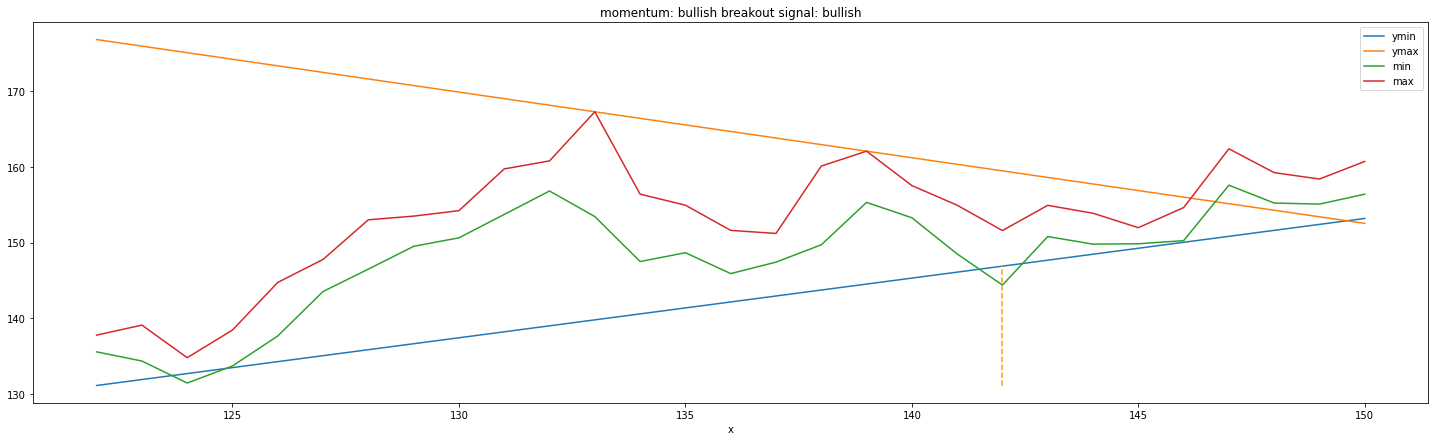

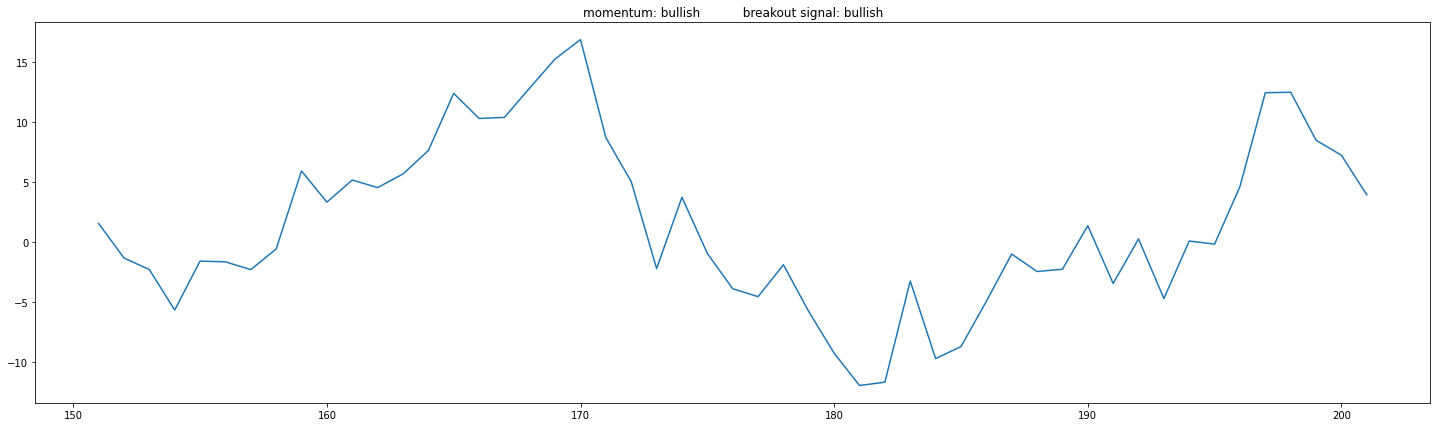

------------------------ validCandle: 229 ------------------------


KeyError: 229

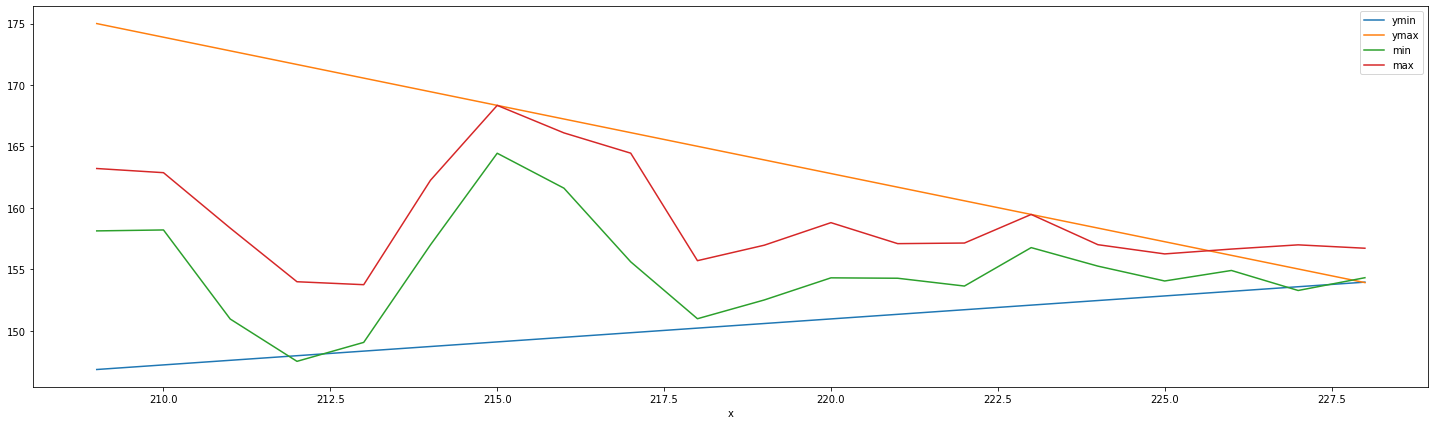

In [223]:
backcandles = 20

warnings.filterwarnings("ignore")
validCandles = searchForValidCandles(df, backcandles=backcandles)
for validCandle in np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]:
    print(f"------------------------ validCandle: {validCandle} ------------------------")
    triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
    opportunity = Opportunity(df, triangle, validCandle, backcandles)
    opportunity.plotEverything()
warnings.filterwarnings("default")

In [224]:
triangle

,ymin,ymax,min,max
x,,,,
209,146.841525,174.998123,158.123505,163.201004
210,147.215805,173.888435,158.199997,162.862503
211,147.590086,172.778748,150.949997,158.350006
212,147.964366,171.66906,147.505997,153.985504
213,148.338647,170.559372,149.048996,153.744995
214,148.712927,169.449684,156.986496,162.242493
215,149.087208,168.339996,164.444,168.339996
216,149.461489,167.230309,161.600006,166.100006
217,149.835769,166.120621,155.605499,164.449997


In [211]:
opportunity.priorTrend

{'min': 264.0033264160156,
 'max': 402.6666564941406,
 'volatility%': 45.9886126635586,
 'change': -52.260009765625}

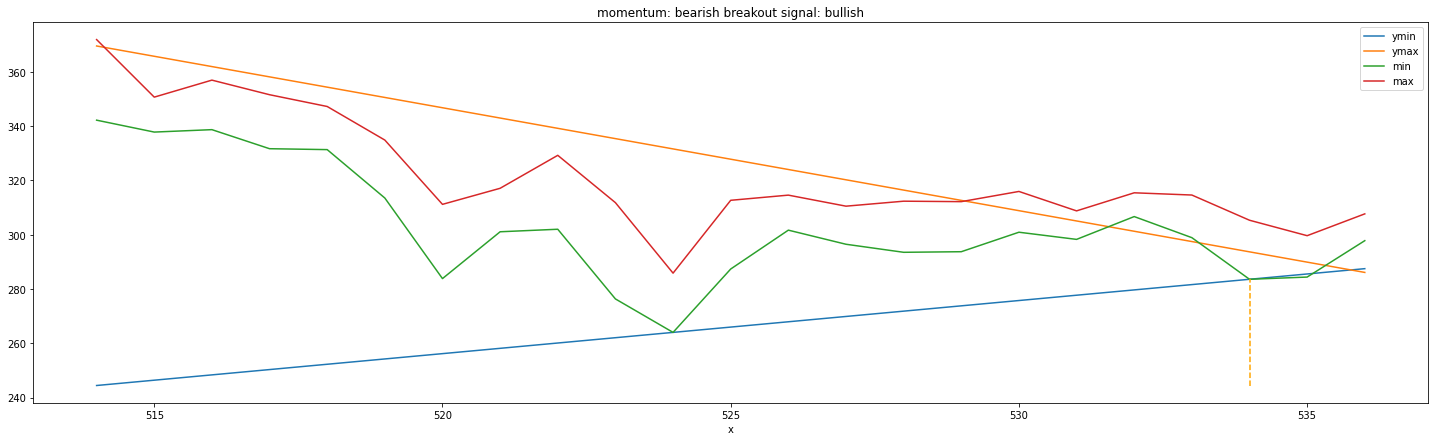

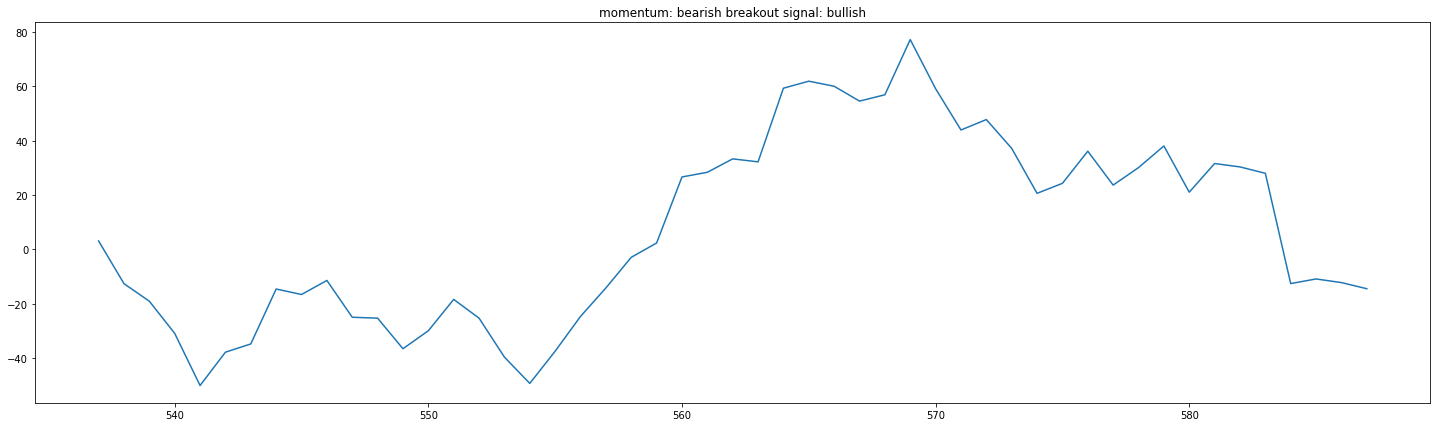

In [209]:
opportunity = Opportunity(df, triangle, validCandle, backcandles)
opportunity.plotEverything()